# 🐂 Modelo de predicción de Estadía en Hospital 🐂

### 1. Importamos las librerías

In [1]:
# IMPORTAR LIBRERIAS
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_context("paper")
from termcolor import colored
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import pickle
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

### 2. Visualizamos la data
para entender el contexto, las relaciones entre ellas y poder llegar a una conclusión.

In [2]:
#Limpiar datos básicos

df=pd.read_csv('dataset/hospitalizaciones_train.csv')
df.head(15)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34
5,2,gynecology,F,Dr Olivia,2,130189,21-30,Female,Trauma,Moderate,Other,2,Yes,4539.268397,11
6,7,gynecology,D,Dr Olivia,5,11175,31-40,Female,Emergency,Moderate,Other,3,Yes,4669.961786,8
7,3,gynecology,B,Dr Sophia,8,82988,21-30,Female,Emergency,Moderate,Heart disease,3,Yes,5101.675480,7
8,2,TB & Chest disease,A,Dr John,7,80339,31-40,Other,Trauma,Moderate,Other,2,No,4899.767616,12
9,4,gynecology,D,Dr Sarah,7,89055,41-50,Female,Trauma,Extreme,Asthama,4,No,3350.366777,8


In [138]:
# Identificar primero las variables categóricas
for columna in df.columns.tolist():
    if len(df[columna].unique().tolist())<=10:
        print(columna,'es variable categorica, \n',df[columna].unique().tolist(),'\n')

Department es variable categorica, 
 ['gynecology', 'anesthesia', 'TB & Chest disease', 'radiotherapy', 'surgery'] 

Ward_Facility_Code es variable categorica, 
 ['D', 'B', 'E', 'F', 'A', 'C'] 

doctor_name es variable categorica, 
 ['Dr Sophia', 'Dr Olivia', 'Dr Mark', 'Dr John', 'Dr Sarah', 'Dr Sam', 'Dr Nathan', 'Dr Simon', 'Dr Isaac'] 

Age es variable categorica, 
 ['41-50', '31-40', '21-30', '71-80', '11-20', '51-60', '61-70', '81-90', '91-100', '0-10'] 

gender es variable categorica, 
 ['Female', 'Male', 'Other'] 

Type of Admission es variable categorica, 
 ['Trauma', 'Urgent', 'Emergency'] 

Severity of Illness es variable categorica, 
 ['Extreme', 'Minor', 'Moderate'] 

health_conditions es variable categorica, 
 ['Diabetes', 'Heart disease', 'None', 'Other', 'Asthama', 'High Blood Pressure'] 

Insurance es variable categorica, 
 ['Yes', 'No'] 



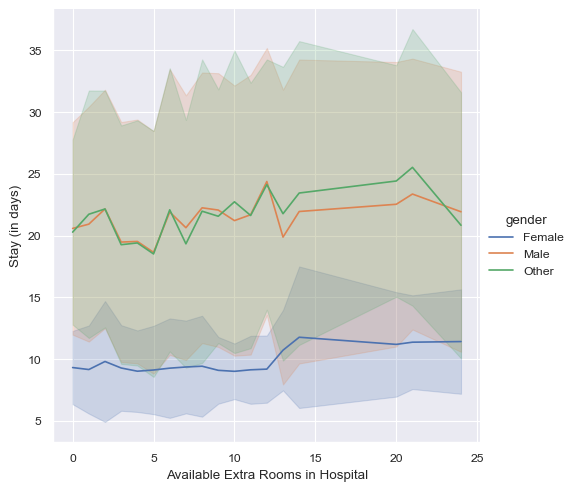

In [139]:
# Available Extra Rooms in Hospital
sns.relplot(data=df, y="Stay (in days)", x="Available Extra Rooms in Hospital", kind="line",errorbar="sd",hue="gender")
#Another good option, especially with larger data, is to represent the spread of the distribution at each timepoint by plotting the standard deviation instead of a confidence interval

In [4]:
extra={}
for i in df["Available Extra Rooms in Hospital"].unique().tolist():
    extra[i]=len(df[df['Stay (in days)']<8][df["Available Extra Rooms in Hospital"]==i][df['Department']=='gynecology'])
extra

C:\Users\Hiros\AppData\Local\Temp\ipykernel_19928\3245260827.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  extra[i]=len(df[df['Stay (in days)']<8][df["Available Extra Rooms in Hospital"]==i][df['Department']=='gynecology'])


{4: 10275,
 2: 9321,
 7: 193,
 3: 9596,
 5: 3573,
 10: 37,
 6: 858,
 1: 925,
 21: 0,
 8: 66,
 11: 47,
 13: 0,
 9: 17,
 14: 0,
 24: 0,
 0: 50,
 12: 51,
 20: 0}

In [141]:
# Department
def over_8(x):
    return x>8
for a in df['Department'].unique().tolist():
    hiro=df[df.Department.isin([a])]['Stay (in days)'].tolist()
    print('Probabilidad de quedarse por',a,':',sum(over_8(x) for x in hiro)/len(hiro))

Probabilidad de quedarse por gynecology : 0.5475685752330226
Probabilidad de quedarse por anesthesia : 1.0
Probabilidad de quedarse por TB & Chest disease : 0.9650464807436919
Probabilidad de quedarse por radiotherapy : 0.6165596250650929
Probabilidad de quedarse por surgery : 0.9995201535508638


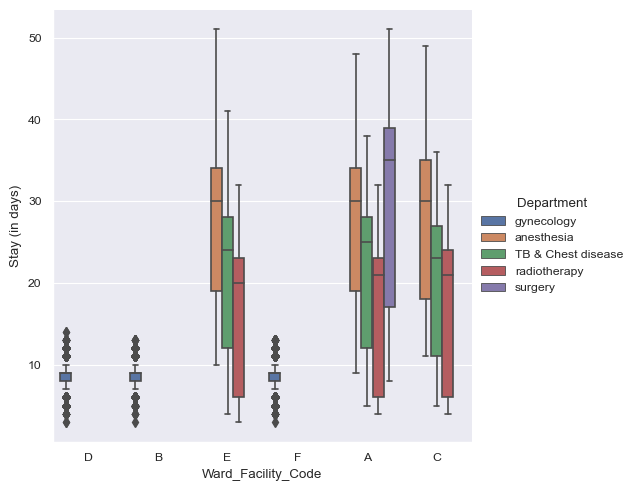

In [143]:
# Ward_Facility_Code
sns.catplot(data=df, y="Stay (in days)", x="Ward_Facility_Code",hue="Department",kind="box")
#Los cuaLos cuartos D, B y F son 'gynecology',por lo que sólo entran mujeres

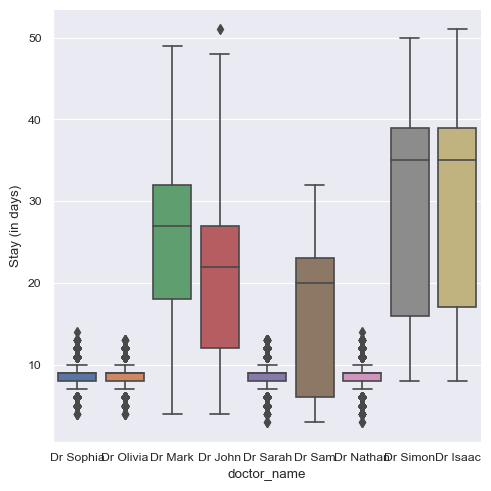

In [144]:
# doctor_name 
sns.catplot(data=df, y="Stay (in days)", x="doctor_name",kind="box")

In [19]:
#Age
for a in df['Age'].unique().tolist():
    hiro=df[df.Age.isin([a])]['Stay (in days)'].tolist()
    print('Probabilidad de quedarse por',a,':',sum(over_8(x) for x in hiro)/len(hiro)*100,'%')

Probabilidad de quedarse por 41-50 : 52.101617328300975 %
Probabilidad de quedarse por 31-40 : 50.834488442662874 %
Probabilidad de quedarse por 21-30 : 59.58942153167097 %
Probabilidad de quedarse por 71-80 : 100.0 %
Probabilidad de quedarse por 11-20 : 56.683895538628946 %
Probabilidad de quedarse por 51-60 : 100.0 %
Probabilidad de quedarse por 61-70 : 100.0 %
Probabilidad de quedarse por 81-90 : 100.0 %
Probabilidad de quedarse por 91-100 : 100.0 %
Probabilidad de quedarse por 0-10 : 100.0 %


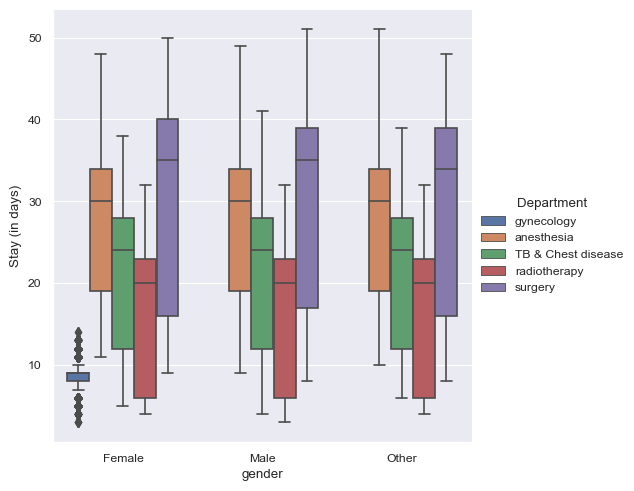

In [20]:
#gender
sns.catplot(data=df, y="Stay (in days)", x="gender",hue='Department',kind="box")

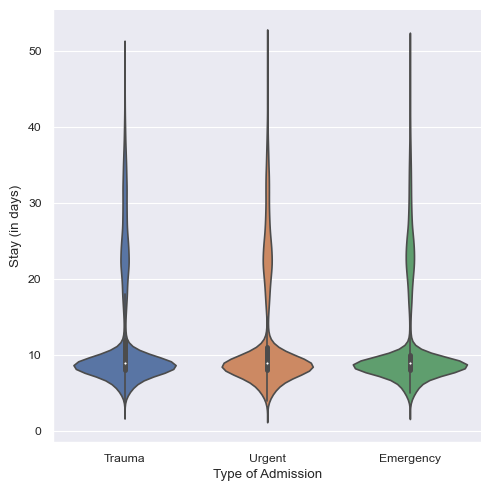

In [21]:
#Type of Admission
sns.catplot(data=df, y="Stay (in days)", x="Type of Admission",kind="violin")

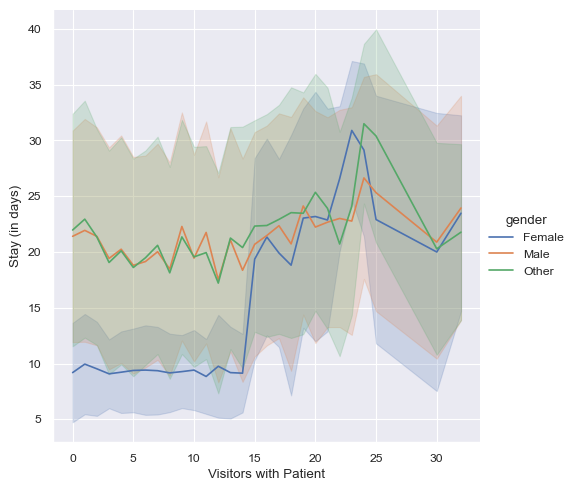

In [24]:
# Visitors with Patient
sns.relplot(data=df, y="Stay (in days)", x="Visitors with Patient", kind="line",errorbar="sd",hue="gender")

<AxesSubplot: xlabel='Stay (in days)'>

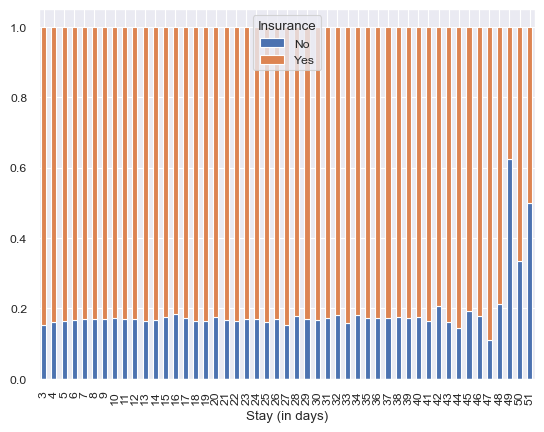

In [25]:
# Insurance
df.groupby('Stay (in days)')['Insurance'].value_counts(normalize=True).unstack('Insurance').plot.bar(stacked=True)

### Filtrar datos Importantes

Vamos a crear una función que si cumple con los siguiente parámetros, directamente regrese un 1.
pero por ahora vamos a filtrarlo para seguir trabajando con los datos actuales.

In [30]:
import pandas as pd
df=pd.read_csv('dataset/hospitalizaciones_train.csv')
df['Stay (in days)'][df['Stay (in days)']<=8]=0
df['Stay (in days)'][df['Stay (in days)']>8]=1
not_filtered_df=df
df=df[df.Age.isin(['41-50', '31-40', '21-30', '11-20'])]
df=df[df.Department.isin(['gynecology', 'TB & Chest disease', 'radiotherapy'])]
#Cambiamos el id por N° de visitas
df['patientid'] = df['patientid'].map(df['patientid'].value_counts().to_dict())
df.head(10)

C:\Users\Hiros\AppData\Local\Temp\ipykernel_6676\2909628216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stay (in days)'][df['Stay (in days)']<=8]=0
C:\Users\Hiros\AppData\Local\Temp\ipykernel_6676\2909628216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stay (in days)'][df['Stay (in days)']>8]=1


,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,3,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0
1,4,gynecology,B,Dr Sophia,2,4,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,1
2,2,gynecology,B,Dr Sophia,8,7,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,0
3,4,gynecology,D,Dr Olivia,7,5,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,0
5,2,gynecology,F,Dr Olivia,2,3,21-30,Female,Trauma,Moderate,Other,2,Yes,4539.268397,1
6,7,gynecology,D,Dr Olivia,5,6,31-40,Female,Emergency,Moderate,Other,3,Yes,4669.961786,0
7,3,gynecology,B,Dr Sophia,8,6,21-30,Female,Emergency,Moderate,Heart disease,3,Yes,5101.675480,0
8,2,TB & Chest disease,A,Dr John,7,5,31-40,Other,Trauma,Moderate,Other,2,No,4899.767616,1
9,4,gynecology,D,Dr Sarah,7,3,41-50,Female,Trauma,Extreme,Asthama,4,No,3350.366777,0
11,3,gynecology,F,Dr Sarah,9,3,11-20,Female,Trauma,Moderate,Asthama,2,No,4013.745709,0


# ------------ CHECKPOINT #1

# Normalización de datos

In [31]:
X = not_filtered_df[['Available Extra Rooms in Hospital',#0
        'Department',#1
        'Ward_Facility_Code',#2
        'doctor_name',#3
        'staff_available',#4
        'patientid',#5
        'Age',#6
        'gender',#7
        'Type of Admission',#8
        'Severity of Illness',#9
        'health_conditions',#10
        'Visitors with Patient',#11
        'Insurance',#12
        'Admission_Deposit']].values

from sklearn import preprocessing

c_dep = preprocessing.LabelEncoder()
c_dep.fit(['gynecology','radiotherapy', 'TB & Chest disease','surgery','anesthesia'])
X[:,1] = c_dep.transform(X[:,1])

c_wfc = preprocessing.LabelEncoder()
c_wfc.fit(['D', 'B', 'F','C' ,'A' ,'E'])
X[:,2] = c_wfc.transform(X[:,2])

c_doctor = preprocessing.LabelEncoder()
c_doctor.fit(['Dr Sophia', 'Dr Olivia', 'Dr Sarah', 'Dr Nathan', 'Dr Simon', 'Dr Isaac', 'Dr Mark', 'Dr Sam', 'Dr John'])
X[:,3] = c_doctor.transform(X[:,3])

c_age = preprocessing.LabelEncoder()
c_age.fit(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'])
X[:,6] = c_age.transform(X[:,6])

c_gender = preprocessing.LabelEncoder()
c_gender.fit(['Female', 'Other','Male'])
X[:,7] = c_gender.transform(X[:,7])

c_adm = preprocessing.LabelEncoder()
c_adm.fit(['Trauma', 'Urgent', 'Emergency'])
X[:,8] = c_adm.transform(X[:,8])

c_sevill = preprocessing.LabelEncoder()
c_sevill.fit(['Minor', 'Moderate','Extreme'])
X[:,9] = c_sevill.transform(X[:,9])

c_cond = preprocessing.LabelEncoder()
c_cond.fit(['Diabetes', 'Heart disease', 'None', 'Other', 'Asthama', 'High Blood Pressure'])
X[:,10] = c_cond.transform(X[:,10])

c_insurance = preprocessing.LabelEncoder()
c_insurance.fit(['Yes', 'No'])
X[:,12] = c_insurance.transform(X[:,12])


y = not_filtered_df['Stay (in days)']
y[0:5]


X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.13348062, -0.01254423,  0.03063266,  1.72683878, -1.58990618,
        -0.72028619,  0.53660816, -0.56948423,  0.27737745, -1.81551151,
        -1.19457239,  0.19910528,  0.45179103, -1.67746672],
       [ 0.13348062, -0.01254423, -1.15337766,  1.72683878, -0.95659681,
        -0.67859366, -0.07746623, -0.56948423,  0.27737745, -0.50855106,
        -0.60015174, -0.69078954, -2.21341268, -1.11567916],
       [-0.60679445, -0.01254423, -1.15337766,  1.72683878,  0.94333129,
        -0.4442471 , -0.69154063, -0.56948423,  0.27737745, -1.81551151,
        -1.19457239, -0.69078954,  0.45179103,  0.86050988],
       [ 0.13348062, -0.01254423,  0.03063266, -0.20382513,  0.62667661,
        -1.4249571 , -0.07746623, -0.56948423,  1.96353753,  0.79840939,
         0.58868957,  0.19910528, -2.21341268,  0.08662244],
       [-0.60679445, -1.454006  ,  0.62263782, -1.16915709,  1.57664066,
         1.10012768,  2.37883134,  1.24908976,  0.27737745,  0.79840939,
        -1.19457239, -0.69

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

In [8]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n,n_jobs=-1).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    print('processing k:',n)
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [6]:
k = mean_acc.argmax()+1

#Train Model and Predict  
knn_general = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = knn_general.predict(X_test)
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [12]:
# Este para entrenar con el 100% de X y y


# k = mean_acc.argmax()+1
# knn_general = KNeighborsClassifier(n_neighbors = k).fit(X,y)
# yhat = knn_general.predict(X)
# print("Test set Accuracy: ", metrics.accuracy_score(y, yhat))

In [34]:
graldf = pd.DataFrame(yhat, columns = ['pred'])
graldf.shape

(410000, 1)

In [35]:
gogo=pd.concat([not_filtered_df,graldf],axis=1)
gogo.head(2)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),pred
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0,1
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,1,0


In [36]:
gogo['y'] = np.nan
gogo['y'] = np.where(gogo['Department'] == "gynecology", gogo['pred'], gogo['y'])
gogo['y'] = np.where(gogo['Department'] == 'TB & Chest disease', gogo['pred'], gogo['y'])
gogo['y'] = np.where(gogo['Department'] == 'radiotherapy', gogo['pred'], gogo['y'])

gogo['y'] = np.where(gogo['Age'].isin(['0-10','51-60','61-70','71-80','81-90','91-100']), 1, gogo['y'])
gogo['y'] = np.where(gogo['Department'].isin(['anesthesia', 'surgery']), 1, gogo['y'])
gogo['y'] = np.where((gogo['Department'] == 'gynecology') & (gogo['Available Extra Rooms in Hospital']>=13), 1, gogo['y'])

gogo.head(3)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days),pred,y
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,0,1,1.0
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,1,0,0.0
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,0,0,0.0
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,0,0,0.0
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409995,1,gynecology,D,Dr Sarah,1,63105,31-40,Female,Trauma,Minor,Asthama,3,Yes,3902.291076,0,0,0.0
409996,5,gynecology,D,Dr Nathan,5,129292,21-30,Female,Trauma,Extreme,Other,4,No,4771.995223,1,0,0.0
409997,4,gynecology,D,Dr Sarah,9,11399,21-30,Female,Emergency,Minor,Asthama,4,Yes,3816.994210,1,1,1.0
409998,10,gynecology,D,Dr Olivia,10,75003,21-30,Female,Trauma,Moderate,Other,2,Yes,3841.577491,1,1,1.0


In [37]:
y_hat=np.array(gogo['y'].tolist())
realy=np.array(not_filtered_df['Stay (in days)'].tolist())
print("Test set Accuracy: ", metrics.accuracy_score(realy, y_hat))

(410000,)

In [40]:
submit = pd.DataFrame(gogo['y'].tolist(), columns = ['pred'])
submit = submit.pred.astype(int)
# guardar el resultado (opcional)
# submit.to_csv('Hi-io_train.csv',index=False)
submit

0         1
1         0
2         0
3         0
4         1
         ..
409995    0
409996    0
409997    1
409998    1
409999    0
Name: pred, Length: 410000, dtype: int32

: 

# test

In [13]:
import pandas as pd
df=pd.read_csv('dataset/hospitalizaciones_test.csv')
not_filtered_test=df
df=df[df.Age.isin(['41-50', '31-40', '21-30', '11-20'])]
df=df[df.Department.isin(['gynecology', 'TB & Chest disease', 'radiotherapy'])]
#Cambiamos el id por N° de visitas
df['patientid'] = df['patientid'].map(df['patientid'].value_counts().to_dict())
df.head(3)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit
0,3,gynecology,F,Dr Olivia,10,1,21-30,Female,Trauma,Moderate,Other,2,No,4749.640225
3,2,gynecology,F,Dr Olivia,1,1,21-30,Female,Trauma,Moderate,None,2,Yes,3987.033318
6,3,gynecology,D,Dr Sarah,6,2,41-50,Female,Urgent,Minor,Asthama,2,No,5348.684488


In [14]:
X = not_filtered_test[['Available Extra Rooms in Hospital',#0
        'Department',#1
        'Ward_Facility_Code',#2
        'doctor_name',#3
        'staff_available',#4
        'patientid',#5
        'Age',#6
        'gender',#7
        'Type of Admission',#8
        'Severity of Illness',#9
        'health_conditions',#10
        'Visitors with Patient',#11
        'Insurance',#12
        'Admission_Deposit']].values

from sklearn import preprocessing

c_dep = preprocessing.LabelEncoder()
c_dep.fit(['gynecology','radiotherapy', 'TB & Chest disease','surgery','anesthesia'])
X[:,1] = c_dep.transform(X[:,1])

c_wfc = preprocessing.LabelEncoder()
c_wfc.fit(['D', 'B', 'F','C' ,'A' ,'E'])
X[:,2] = c_wfc.transform(X[:,2])

c_doctor = preprocessing.LabelEncoder()
c_doctor.fit(['Dr Sophia', 'Dr Olivia', 'Dr Sarah', 'Dr Nathan', 'Dr Simon', 'Dr Isaac', 'Dr Mark', 'Dr Sam', 'Dr John'])
X[:,3] = c_doctor.transform(X[:,3])

c_age = preprocessing.LabelEncoder()
c_age.fit(['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'])
X[:,6] = c_age.transform(X[:,6])

c_gender = preprocessing.LabelEncoder()
c_gender.fit(['Female', 'Other','Male'])
X[:,7] = c_gender.transform(X[:,7])

c_adm = preprocessing.LabelEncoder()
c_adm.fit(['Trauma', 'Urgent', 'Emergency'])
X[:,8] = c_adm.transform(X[:,8])

c_sevill = preprocessing.LabelEncoder()
c_sevill.fit(['Minor', 'Moderate','Extreme'])
X[:,9] = c_sevill.transform(X[:,9])

c_cond = preprocessing.LabelEncoder()
c_cond.fit(['Diabetes', 'Heart disease', 'None', 'Other', 'Asthama', 'High Blood Pressure'])
X[:,10] = c_cond.transform(X[:,10])

c_insurance = preprocessing.LabelEncoder()
c_insurance.fit(['Yes', 'No'])
X[:,12] = c_insurance.transform(X[:,12])




X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.23722367, -0.01705613,  1.21583708, -0.26467164,  1.57724143,
        -1.45170013, -0.69918796, -0.47687446,  0.27410233,  0.82099814,
         1.42903342, -0.69419267, -1.18216183,  0.03090309],
       [-0.61011262, -2.90249126,  0.62227934, -1.46993622, -0.32240098,
         0.05414021,  1.13841619, -0.47687446,  0.27410233,  0.82099814,
        -1.46486633, -0.69419267,  0.84590787, -0.56838609],
       [-0.61011262,  1.42566144,  0.62227934, -1.46993622,  0.62742022,
        -0.42684916,  1.13841619,  2.76117309,  0.27410233,  0.82099814,
         0.85025347, -0.24202844, -1.18216183,  0.70856745],
       [-0.61011262, -0.01705613,  1.21583708, -0.26467164, -1.27222218,
        -0.77372548, -0.69918796, -0.47687446,  0.27410233,  0.82099814,
         0.85025347, -0.69419267,  0.84590787, -0.69755952],
       [-0.61011262, -1.45977369, -1.75195163, -1.46993622,  0.62742022,
         1.47761361,  1.13841619, -0.47687446,  0.27410233, -1.74444288,
        -0.88608638, -0.69

In [15]:
yhat = knn_general.predict(X)

In [16]:
graldf = pd.DataFrame(yhat, columns = ['pred'])
gogo=pd.concat([not_filtered_test,graldf],axis=1)
gogo

(90000, 1)

In [25]:
gogo['y'] = np.nan
gogo['y'] = np.where(gogo['Department'] == "gynecology", gogo['pred'], gogo['y'])
gogo['y'] = np.where(gogo['Department'] == 'TB & Chest disease', gogo['pred'], gogo['y'])
gogo['y'] = np.where(gogo['Department'] == 'radiotherapy', gogo['pred'], gogo['y'])

gogo['y'] = np.where(gogo['Age'].isin(['0-10','51-60','61-70','71-80','81-90','91-100']), 1, gogo['y'])
gogo['y'] = np.where(gogo['Department'].isin(['anesthesia', 'surgery']), 1, gogo['y'])
gogo['y'] = np.where((gogo['Department'] == 'gynecology') & (gogo['Available Extra Rooms in Hospital']>=13), 1, gogo['y'])
gogo.shape
gogo.head(3)

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,pred,y
0,3,gynecology,F,Dr Olivia,10,2858,21-30,Female,Trauma,Moderate,Other,2,No,4749.640225,0,0.0
1,2,TB & Chest disease,E,Dr John,4,65657,51-60,Female,Trauma,Moderate,Asthama,2,Yes,4122.261324,1,1.0
2,2,radiotherapy,E,Dr John,7,45598,51-60,Other,Trauma,Moderate,None,3,No,5459.067882,1,1.0
3,2,gynecology,F,Dr Olivia,1,31132,21-30,Female,Trauma,Moderate,None,2,Yes,3987.033318,1,1.0
4,2,anesthesia,A,Dr John,7,125021,51-60,Female,Trauma,Extreme,Diabetes,2,No,4770.789695,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,4,gynecology,F,Dr Sarah,2,43001,11-20,Female,Trauma,Minor,High Blood Pressure,3,No,4105.795901,1,1.0
89996,13,gynecology,F,Dr Olivia,8,85601,31-40,Female,Emergency,Moderate,Other,2,No,4631.550257,1,1.0
89997,2,gynecology,B,Dr Sarah,3,22447,11-20,Female,Emergency,Moderate,High Blood Pressure,2,No,5456.930075,0,0.0
89998,2,radiotherapy,A,Dr John,1,29957,61-70,Female,Trauma,Extreme,Diabetes,2,No,4694.127772,1,1.0


In [26]:
y_hat=np.array(gogo['y'].tolist())
y_hat.shape
realy=np.array(not_filtered_test['Stay (in days)'].tolist())
submit = pd.DataFrame(gogo['y'].tolist(), columns = ['pred'])
submit = submit.pred.astype(int)
submit.to_csv('Hi-io.csv',index=False)
submit

(90000,)

In [29]:
submit = pd.DataFrame(gogo['y'].tolist(), columns = ['pred'])
submit = submit.pred.astype(int)
submit.to_csv('Hi-io.csv',index=False)
submit

0        0
1        1
2        1
3        1
4        1
        ..
89995    1
89996    1
89997    0
89998    1
89999    1
Name: pred, Length: 90000, dtype: int32